In [ ]:
%load_ext autoreload
%autoreload 2

In [19]:
from modulus.distributed import DistributedManager
from modulus.utils_new.caching import Cache
from modulus.models_new.graphcast.graph_cast_net import GraphCastNetNew

DistributedManager.initialize()
dist = DistributedManager()
Cache.initialize(dir="/iopsstor/scratch/cscs/stefschu/DSM500/cache")

model = GraphCastNetNew(
    sample_resolution=[721, 1440],
    input_channels=31,
    output_channels=21
)
model = model.to("cuda")

/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/distributed/manager.py:346: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(


In [20]:
dir(dist)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_broadcast_buffers',
 '_cuda',
 '_device',
 '_distributed',
 '_find_unused_parameters',
 '_group_names',
 '_group_ranks',
 '_groups',
 '_initialization_method',
 '_is_initialized',
 '_local_rank',
 '_rank',
 '_shared_state',
 '_world_size',
 'broadcast_buffers',
 'cleanup',
 'create_group_from_node',
 'create_groups_from_config',
 'create_orthogonal_process_group',
 'create_process_subgroup',
 'cuda',
 'device',
 'distributed',
 'find_unused_parameters',
 'get_available_backend',
 'group',
 'group_name',
 'group_names',
 'group_rank',
 'group_size',
 'initialize',
 'initialize_env',
 'initialize_open_mpi',
 'initialize_s

In [ ]:
dist

: 

In [3]:
from torch.nn.parallel import DistributedDataParallel

ddp_model = DistributedDataParallel(
    model,
    device_ids=[dist.local_rank],
    output_device=dist.device,
    broadcast_buffers=dist.broadcast_buffers,
    find_unused_parameters=dist.find_unused_parameters,
    gradient_as_bucket_view=True, # Function: Allows gradients to be viewed as part of a larger contiguous buffer.
                                  # Default Behavior: False (gradients are separate).
                                  # Use Case: True reduces memory overhead and improves performance by avoiding copies.
    static_graph=True, # Function: Allows the graph to be static.
                       # Default Behavior: False (DDP assumes model structure can change).
                       # Use Case: True improves efficiency if model architecture is static.
)

ValueError: Default process group has not been initialized, please make sure to call init_process_group.

In [ ]:
model.__class__.__name__

'GraphCastNet'

In [21]:
import torch
from modulus.datapipes.climate.era5_hdf5_new import ERA5HDF5Datapipe
datapipe = ERA5HDF5Datapipe(
    base_path="/iopsstor/scratch/cscs/stefschu/DSM500/data/FCN_ERA5_data_v0",
    data_folder="train",
    shuffle=False,
)

data = next(iter(datapipe))

input = data[0]["input"]
input_ts = data[0]["input_timestamps"]
output = data[0]["output"]

input = input.to("cuda")

input = torch.cat([input, input], dim=0)
input.shape

torch.Size([2, 1, 31, 721, 1440])

In [22]:
dir(datapipe)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_create_pipeline',
 '_is_gpu',
 '_load_static_data',
 '_load_statistics',
 'batch_size',
 'device_index',
 'file_paths',
 'latlon',
 'mu',
 'num_steps',
 'num_threads',
 'pipe',
 'prefetch_queue_depth',
 'py_num_workers',
 'rank',
 'shuffle',
 'static_data',
 'std',
 'world_size']

In [25]:
s = 123
print(f"Seed: {s:5d}")

Seed:   123


In [29]:
output = model(input)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1038240 but got size 2076480 for tensor number 1 in the list.

In [15]:
output.shape

torch.Size([1, 21, 721, 1440])

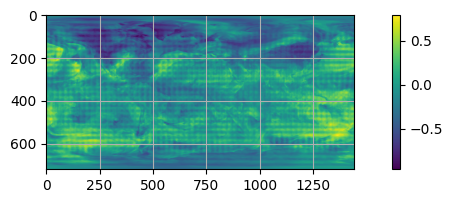

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 2))
im = plt.imshow(output[0, 2].cpu().detach())
plt.grid(True)
plt.colorbar(im)
plt.show()